# Prompt Caching with LLaMa 3.2

> This notebook provides a detailed exploration of prompt caching using Llama 3.2, based on the paper "[*Prompt Cache: Modular Attention Reuse for Low-Latency Inference*](https://arxiv.org/pdf/2311.04934)". We'll implement prompt caching from scratch and demonstrate its benefits for inference speed.

# Introduction

Before we continue, let's break down the key concepts from the prompt cache paper.

**I highly, highly recommend going through my `kv_caching.ipynb` notebook before this one if you aren't already familiar with kv caching!** I will give a *very* brief overview in this notebook, but for the most part assume that most of the details of why and how KV caching is done are already understood by the reader.

The core idea that the paper observes is that many prompts share common segments (like system messages or templates), but these segments get recomputed every time they appear. Even with KV caching, the cache is stored *during generation of a single output* and, while it *can* be re-used for another generation with the identical prompt, it's typically erased once the prompt changes, even if only slightly. The goal of prompt caching is to precompute and store attention states for common segments so that they can be easily reused.


## Key Components:

**Prompt Modules:**

Prompt modules are reusable segments of text (like system messages or documents) that are explicitly defined in a schema with their own position IDs, allowing their attention states to be cached and reused. The modules are defined using a markup language that specifies how they can be combined and parameterized, similar to how you might define reusable components in XML.


**Schemas:**

A schema defines how prompt modules can be combined. They specify what are valid positions and relationships between modules.
Example: A schema might specify that a system message comes first, followed by either a code snippet or a document, then a user query. Each of these components of a schema are their own prompt modules.


**Storage:**

For each module, the actual data that gets stored is:

- The K (Key) and V (Value) attention states
- The position IDs used when computing those states
- The module's boundaries and metadata


**Mixing and Matching:**

Each module reserves a "slot" of position IDs, and when combining modules, original position IDs are preserved within each module.
This works because transformer attention is invariant to gaps in position IDs
The K,V states from different modules can be concatenated as long as their relative positions are maintained.

## The Key Idea:

While the underlying caching methodology that's used by prompt caching is just storing the KV states, the concept of prompt modules provides a structured way to:

1. Define what pieces of prompts are reusable
2. Manage their position assignments
3. Control how they can be combined
4. Handle variations through parameters


Below is a figure from the paper demostrating how traditional generation, generation with KV cache, and generation with a prompt cache are all different.

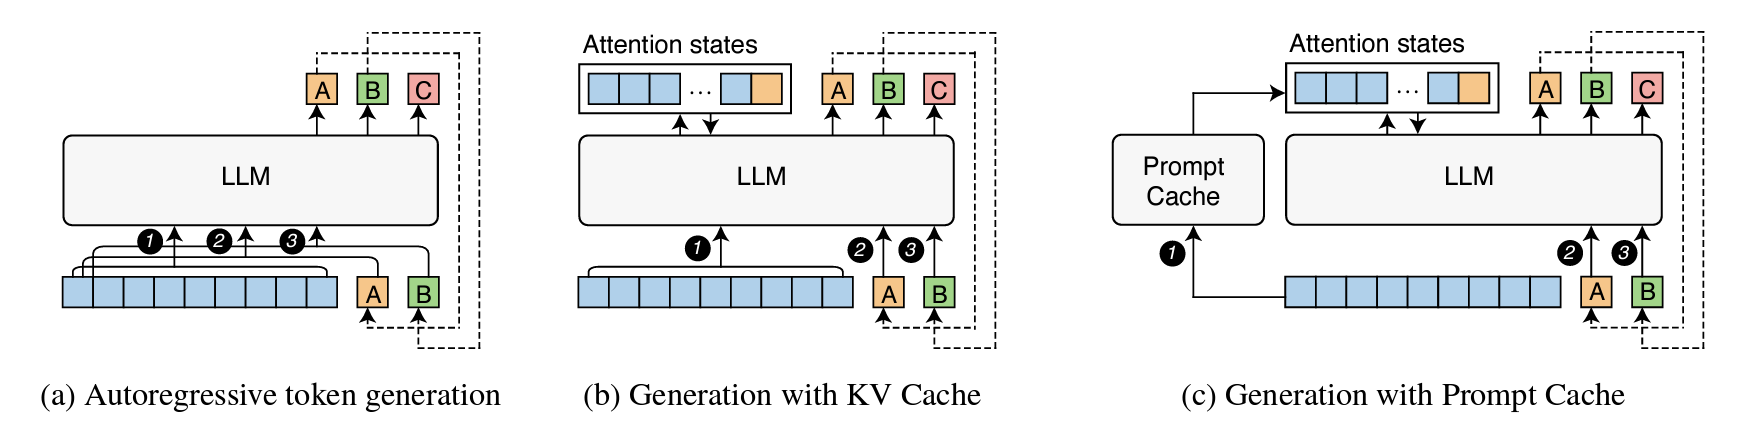

In [125]:
from IPython.display import Image, display
image = Image(filename='paper_fig1.png')
display(image)

# Introduction and Setup
Before we get any deeper into code, let's install necessary packages and import dependencies:

In [126]:
# Install required packages
!pip install -q --upgrade transformers datasets

In [127]:
# Standard libraries
import re
import os
import time
from typing import List, Tuple, Dict, Set, Optional
from dataclasses import dataclass
from enum import Enum

# AI/ML Libraries
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.cache_utils import DynamicCache

In [128]:
# Check PyTorch version and CUDA availability
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA device: Tesla T4
Available GPU memory: 14.75 GB


# Loading and Testing our Model

Let's start by loading a small LLM to demonstrate these concepts, and looking at its output before we do anything. We'll use LLaMa 3.2 1B. This model is excellent for this example because:
1. It is small enough to run on smaller GPUs
2. It uses a relatively simple transformer architecture, making it easier to understand the core concepts
3. Despite its small size, it produces coherent enough outputs to demonstrate the effects of caching on generation

## Hugging Face Authentication

LLaMa 3.2 requires authentication with Hugging Face to access the model. You'll need to:
1. Have a Hugging Face account
2. Accept the LLaMa 3.2 model terms of use on the Hugging Face model page
3. Create an access token on Hugging Face (https://huggingface.co/settings/tokens)

After you have your access token and have accepted the terms, the code below will help you log in:

In [129]:
from huggingface_hub import login
import getpass

token = getpass.getpass("Enter your Hugging Face token: ")
login(token=token)

# Verify login
print("Login status: Authenticated with Hugging Face")


Enter your Hugging Face token: ··········
Login status: Authenticated with Hugging Face


In [130]:
model_name = "meta-llama/Llama-3.2-1B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2048,), eps=1e-05)
    (rotary_emb):

# Inspecting the LLaMa Architecture

Let's break down the Llama architecture with a focus on the parts relevant to prompt caching!

**Overall Structure:**

- The model has 16 layers of LlamaDecoderLayer (seen in `(0-15): 16 x`)
- Each layer has a self-attention block and an MLP block
- The embedding dimension is 2048 (seen in many places)


**The Most Important Part - The Attention Block:**
```
(self_attn): LlamaAttention(
    (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
    (k_proj): Linear(in_features=2048, out_features=512, bias=False)
    (v_proj): Linear(in_features=2048, out_features=512, bias=False)
    (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
)
```

This shows us:

- Q (query) projector takes 2048 dimensions to 2048
- K (key) projector takes 2048 dimensions to 512
- V (value) projector takes 2048 dimensions to 512
- The output projector takes 2048 back to 2048

The 512 dimension is actually head_dim $\times$ num_heads. Since $K$ and $V$ are 512, and Llama uses 8 KV heads (we will see this below), each head must be working with 64-dimensional vectors (512/32 = 64).

We can see this when we look at the model's config:


In [131]:
# Get model configuration
config = model.config
print("Model Configuration:")
print(f"Number of heads: {config.num_attention_heads}")
print(f"Hidden size: {config.hidden_size}")
print(f"Head dimension: {config.hidden_size // config.num_attention_heads}")

# Get first layer's attention module
first_layer = model.model.layers[0]
attention = first_layer.self_attn

# Print key dimensions
print("\nAttention Component Dimensions:")
print(f"Q projection: {attention.q_proj.weight.shape}")
print(f"K projection: {attention.k_proj.weight.shape}")
print(f"V projection: {attention.v_proj.weight.shape}")

# Print attention attributes
print("\nAttention Module Attributes:")
for name, value in vars(attention).items():
    if not name.startswith('_'):
        print(f"{name}: {value}")

Model Configuration:
Number of heads: 32
Hidden size: 2048
Head dimension: 64

Attention Component Dimensions:
Q projection: torch.Size([2048, 2048])
K projection: torch.Size([512, 2048])
V projection: torch.Size([512, 2048])

Attention Module Attributes:
training: False
config: LlamaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "meta-llama/Llama-3.2-1B",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128001,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 16,
  "num_key_value_heads": 8,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": {
    "factor": 32.0,
    "high_freq_factor": 4.0,
    "low_freq_factor": 1.0,
    "original_max_position_em

**One Note:**
Llama 3.2 uses *Grouped Query Attention (GQA)*, where:

- There are 32 query ($Q$) heads
- But only 8 key-value ($K,V$) heads
- So each $K,V$ head is shared by 4 $Q$ heads (32/8 = 4)

The config shows 32 heads (the total number of $Q$ heads), but `num_key_value_groups: 4`  means each $K,V$ head is shared by 4 $Q$ heads

This also explains in more detail the the projection shapes we saw above:

- $Q$ projection: [2048, 2048] -> 32 heads × 64 dimensions = 2048
- $K,V$ projections: [512, 2048] -> 8 heads × 64 dimensions = 512

So when we're caching $K,V$ states, we only need to store 8 heads worth of information, even though the model is using 32 $Q$ heads during attention computation. This is a memory optimization technique that Llama uses!

## Inspecting the Cache

When caching, we're storing the outputs of the `k_proj` and `v_proj` for each layer. The cache shape would be:

Batch dimension    $ \times $   Number of layers (16) $\times$     2 tensors per layer ($K$ and $V$)

→ For each tensor: `[num_heads=8, seq_len, head_dim=64]`

We can see this by examining the cache:

In [132]:
example_prompt = "This is an example input."
input_ids = tokenizer(example_prompt, return_tensors="pt").input_ids.to(device)

#How the word was tokenized
print("\nTokens:")
for i, token_id in enumerate(input_ids[0]):
    print(f"{i}: {tokenizer.decode([token_id])}")
print("( length:", len(input_ids[0]), ")\n")

outputs = model(
    input_ids,
    use_cache=True, # the model is smart, and will keep track of what must be cached for us
    return_dict=True
)

cache = outputs.past_key_values # get those cached values here

print("Cache structure:")
print(f"Number of layers: {len(cache)}")
print(f"Items per layer: {len(cache[0])}  # K and V")
k_states, v_states = cache[0]  # Look at first layer
print(f"K states shape: {k_states.shape}")
print(f"V states shape: {v_states.shape}")


Tokens:
0: <|begin_of_text|>
1: This
2:  is
3:  an
4:  example
5:  input
6: .
( length: 7 )

Cache structure:
Number of layers: 16
Items per layer: 2  # K and V
K states shape: torch.Size([1, 8, 7, 64])
V states shape: torch.Size([1, 8, 7, 64])


Breaking down the dimensions of these output $K$ and $V$ shapes: `torch.Size([1, 8, 7, 64])`

- **First dimension [1]**: This is the batch size. Since we're processing one prompt at a time, it's 1.
- **Second dimension [8]**: This represents the number of attention heads. Each head can learn to attend to different aspects of the input.
- **Third dimension [7]**: Sequence length. We can see that our example prompt was tokenized as 7 tokens.
- **Fourth dimension [64]**: This is the dimension per head (head_dim). Each head processes attention in a 64-dimensional space.

So when we store $K$ and $V$ states, we're storing:

For each layer (16 of them):

> For both $K$ and $V$:
>
>>A tensor that has:
>>
>>> Each head's (8) representation of each token (seq_length) as a 64-dimensional vector
>>>
>>> → an `[8,seq_length,64]` vector
>>
>> → 2 `[8,seq_length,64]` vectors
>
> → 16 $\times$ 2 `[8,seq_length,64]` vectors for a given prompt that's tokenized into `seq_length` tokens

This is exactly what we store in a prompt module - these KV states for each layer.

#A Basic Implementation

Let's move on to actually building a prompt caching implementation. We'll start by going over the core components to prompt caching and exploring how we use them in practice.

## Core Component #1: Prompt Module

Let's start by investigating the concept of a prompt module more in depth, and building a simple one.

When we cache a prompt module, we're storing:

- The module's text and metadata (name, position info, etc.)
- All those KV states we just analyzed:

  For each of the 16 layers

  Both K and V for each layer
  
  Each with shape [1, 8, seq_length, 64]

### A (simple) example prompt module

Let's start by building the framework for a very simple prompt module. Here, we'll build a simple prompt module class that can create a cache for us for a given prompt section.

In [133]:
class SimplePromptModule:
    def __init__(self, text: str):
        self.text = text
        self.cached_kv_states = None
        self.input_length = None

    def compute_and_cache_states(self, model, tokenizer):
        tokens = tokenizer(
            self.text,
            return_tensors="pt",
            return_attention_mask=True
        ).to(model.device)

        self.input_length = tokens.input_ids.shape[1]

        with torch.no_grad():
            outputs = model(
                tokens.input_ids,
                attention_mask=tokens.attention_mask,
                use_cache=True,
                return_dict=True
            )

        self.cached_kv_states = outputs.past_key_values

In [134]:
# Create and cache a simple module
system_prompt = SimplePromptModule("You are a helpful AI assistant.")
system_prompt.compute_and_cache_states(model, tokenizer)

# Let's look at what we cached
print("Number of layers:", len(system_prompt.cached_kv_states))
first_layer_k, first_layer_v = system_prompt.cached_kv_states[0]
print("K shape:", first_layer_k.shape)
print("V shape:", first_layer_v.shape)

Number of layers: 16
K shape: torch.Size([1, 8, 8, 64])
V shape: torch.Size([1, 8, 8, 64])


Now, we can write a simple function that calls on this cache at generation time.

This function is largely copied from the end of my **`kv_caching.ipynb`** notebook, so I won't go into too many details about the exact details of this function, but we'll utilize our saved KV states and feed them back into the model as we generate the tokens that follow our cached system prompt + new prompt.


In [135]:
def generate_with_cached_prompt(
    model,
    tokenizer,
    prompt_module: SimplePromptModule,
    continuation: str,
    max_length: int = 50,
    temperature = .7
):
    # Get tokens for the continuation
    continuation_ids = tokenizer.encode(continuation, return_tensors='pt').to(model.device)

    with torch.no_grad():
        # First forward pass using continuation and cached states
        outputs = model(
            continuation_ids,
            past_key_values=prompt_module.cached_kv_states,
            use_cache=True,
            return_dict=True
        )

        generated_sequence = continuation_ids
        generated_text = []

        # Generate tokens one at a time
        for _ in range(max_length):
            # Get logits for next token prediction
            next_token_logits = outputs.logits[:, -1, :]
            next_token = torch.multinomial(torch.softmax(next_token_logits / temperature, dim=-1), num_samples=1)

            # Keep track of the sequence
            generated_sequence = torch.cat([generated_sequence, next_token], dim=-1)
            generated_text.append(next_token.item())

            # Forward pass for next token
            outputs = model(
                next_token,
                use_cache=True,
                past_key_values=outputs.past_key_values,
                return_dict=True
            )

            if next_token.item() == tokenizer.eos_token_id:
                break

    return tokenizer.decode(generated_text, skip_special_tokens=True)


In [136]:
output = generate_with_cached_prompt(
    model,
    tokenizer,
    system_prompt, # use the system prompt, which we've now conventiently already cached!
    "Tell me about neural networks."
)
print("\nOutput:", output)


Output:  It's a topic that's a little confusing. Explain the basics of artificial intelligence and neural networks, and the different kinds of artificial neural networks. I'm confused about the difference between feedforward and recurrent neural networks. I want to know which type of


## Core Component #2: Prompt Schemas

So far, we've seen just storing the KV states for a single system prompt, and inserting those states at the beginning of generation. We've seen what organizing it as a module could look like, but besides that, our implementation so far has largely been just standard KV caching.

The real idea behind prompt caching is that different prompt modules can be mixed and matched together. This is done with **prompt schemas**, which are the higher-level containers that defines:

1. What modules exist
2. Their positions/ordering
3. How they can be combined
4. Parameters they can take

### A (simple) schema example

We'll start with a very simple schema implementation first, since it provides the structural foundation for how modules work.

The schema below will give us a minimal foundation that just:

- Stores modules by name
- Can cache all modules at once

In [137]:
class SimpleSchema:
    """A basic schema that just stores and manages prompt modules."""

    def __init__(self, name: str):
        self.name = name
        self.modules = {}  # name -> SimplePromptModule

    def add_module(self, name: str, text: str):
        """Add a module to the schema."""
        module = SimplePromptModule(text)
        self.modules[name] = module
        return module

    def cache_all(self, model, tokenizer):
        """Compute and cache states for all modules."""
        print(f"Caching states for schema '{self.name}':")
        for name, module in self.modules.items():
            print(f"  Caching module '{name}'...")
            module.compute_and_cache_states(model, tokenizer)

Let's define this schema and add some prompts to it.

In [138]:
# Create a schema
schema = SimpleSchema("qa_schema")

# Add a few modules
schema.add_module("system", "You are a helpful AI assistant.")
schema.add_module("python_doc", "Python is a programming language known for its readability.")

# Cache all modules
schema.cache_all(model, tokenizer)

Caching states for schema 'qa_schema':
  Caching module 'system'...
  Caching module 'python_doc'...


In [139]:
# Try using just one module first (using our working generate_with_cached_prompt)
output = generate_with_cached_prompt(
    model,
    tokenizer,
    schema.modules["system"],
    "Tell me about coding.",
    max_length=50
)
print("\nGenerated:", output)


Generated:  This is your second day and I’m sure you’re going to be amazing. You’re good with math, science, and you have a strong understanding of coding. You are asking the question, “Are you good enough to be an AI assistant?”


### Modules are part of schemas

A module becomes a part of a schema. Indeed, we can inspect the KV states that we were storing for just our module vs for our module now that it's stored as part of a schema, and see that they are identical.

In [140]:
def inspect_cached_states(prompt_module: SimplePromptModule):
    """Print the first few values of the cached K,V states."""
    if prompt_module.cached_kv_states is None:
        print("No cached states!")
        return

    # Look at first layer's first few values
    k, v = prompt_module.cached_kv_states[0]  # First layer
    print(f"First 5 values of K: {k[0, 0, 0, :5]}")  # First batch, head, token, first 5 dims
    print(f"First 5 values of V: {v[0, 0, 0, :5]}")

# Test prompt module
print("Original version:")
system_prompt = SimplePromptModule("You are a helpful AI assistant.")
system_prompt.compute_and_cache_states(model, tokenizer)
inspect_cached_states(system_prompt)

# Test schema version
print("\nSchema version:")
schema = SimpleSchema("qa_schema")
schema.add_module("system", "You are a helpful AI assistant.")
schema.cache_all(model, tokenizer)
inspect_cached_states(schema.modules["system"])

Original version:
First 5 values of K: tensor([ 0.0956,  0.1783,  0.0368, -0.2105, -0.2119], device='cuda:0')
First 5 values of V: tensor([ 0.0026,  0.0136, -0.0450, -0.0029, -0.0004], device='cuda:0')

Schema version:
Caching states for schema 'qa_schema':
  Caching module 'system'...
First 5 values of K: tensor([ 0.0956,  0.1783,  0.0368, -0.2105, -0.2119], device='cuda:0')
First 5 values of V: tensor([ 0.0026,  0.0136, -0.0450, -0.0029, -0.0004], device='cuda:0')


# Adding Addtional Functionalities

Now that we've gotten the basics down, it's time to add enough complexity to take full advantage of prompt caching.

Although so far we've written a prompt module and wrapped it in a schema, we still have:

- No position management - can't control where modules go in relation to each other
- No module parameters - text is static
- Can't combine multiple modules yet
- No validation of module combinations

Let's build out a prompt module / schema system that allows this.


## Position Handling

We want to combine multiple prompt modules to fully take advantage of prompt caching. In order to do that, we need to manage the relative positions of our modules. And it isn't just about order - it's about preserving the exact positions that were used when we cached the attention states. To do so:

- Each module gets assigned a range of position IDs
- These positions determine where modules can go in relation to each other
- When combining modules, their relative positions must be maintained
- We can have gaps between positions - the attention mechanism can handle discontinuous position IDs

This matters because, in transformer models like Llama:

1. Each token's attention calculation includes positional information
2. When we cache K,V states, they include this positional information
3. To reuse cached states, we need to use them in positions that match how they were cached

We'll create a position class that tracks:

- Where a module starts (start)
- How long it is (length)
- Where it ends (end)

Then, each module reserves a range of positions.

In [141]:
@dataclass
class Position:
    """Tracks the position range for a module."""
    start: int  # Starting position of the module
    length: int  # Length of the module in tokens

    @property
    def end(self) -> int:
        """End position of the module (exclusive)."""
        return self.start + self.length

    def overlaps_with(self, other: 'Position') -> bool:
        """Check if this position overlaps with another."""
        return not (self.end <= other.start or other.end <= self.start)

def validate_module_sequence(positions: List[Position]):
    """
    Validate that a sequence of module positions does not overlap.
    Ensures that precomputed KV states are positionally consistent.
    """
    for i in range(len(positions)):
        for j in range(i + 1, len(positions)):
            if positions[i].overlaps_with(positions[j]):
                raise ValueError(
                    f"Position conflict: {positions[i]} overlaps with {positions[j]}"
                )

We also validate our positions, to make sure that nothing is trying to insert into the same slot:

In [142]:
system_pos = Position(start=0, length=10)
context_pos = Position(start=20, length=15)  # Note gap between 10-20
user_pos = Position(start=40, length=5)     # Note gap between 35-40

# This should work:
validate_module_sequence([system_pos, context_pos])
validate_module_sequence([context_pos, user_pos])

# This would raise an error:
try:
    conflicting_pos = Position(start=5, length=10)  # Overlaps with system_pos
    validate_module_sequence([system_pos, conflicting_pos])
except ValueError as e:
    print(f"Caught expected error: {e}")

Caught expected error: Position conflict: Position(start=0, length=10) overlaps with Position(start=5, length=10)


You might be asking "Why doesn't attention care about discontinuous position IDs?"

When a transformer processes tokens, each token's position is used to calculate positional embeddings that inform how that token attends to other tokens. In Llama's case, this uses rotary position embeddings (RoPE).
The key insight is: attention calculations only care about relative positions between tokens, not absolute positions. When token A at position 5 attends to token B at position 3, what matters is their relative distance (2 positions), not their absolute positions.
This means:

- Sequence [0,1,2,3] and sequence [100,101,102,103] will produce the same attention patterns
- A gap like [0,1,2,10,11,12] doesn't disrupt attention - tokens still know their relative positions to each other
- The model never assumes positions are continuous - it just uses whatever positions it's given to calculate relative distances

Therefore, when we cache KV states from discontinuous positions and combine them, each token's stored states still contain the correct relative position information they had when they were cached. The attention mechanism can use these just fine, as it only cares about preserving those relative relationships.

In [143]:
def combine_states_with_positions(
    cached_states_list: List[Tuple[List[Tuple[torch.Tensor, torch.Tensor]], Position]]
) -> List[Tuple[torch.Tensor, torch.Tensor]]:
    """
    Combine KV states from multiple modules, respecting their positions.

    Args:
        cached_states_list: List of (cached_states, position) pairs
            cached_states is the KV states for one module
            position is where those states should go
    """
    # Sort by position
    cached_states_list = sorted(cached_states_list, key=lambda x: x[1].start)

    # Validate no overlaps
    positions = [pos for _, pos in cached_states_list]
    validate_module_sequence(positions)

    # Initialize with first module's states
    first_states, _ = cached_states_list[0]
    combined_states = list(first_states)

    # Add remaining modules' states
    for module_states, _ in cached_states_list[1:]:
        for layer_idx in range(len(combined_states)):
            k_combined, v_combined = combined_states[layer_idx]
            k_module, v_module = module_states[layer_idx]

            # Concatenate along sequence dimension
            combined_states[layer_idx] = (
                torch.cat([k_combined, k_module], dim=2),
                torch.cat([v_combined, v_module], dim=2)
            )

    return combined_states

In [144]:
"""Demonstrate how positions affect state combination."""
# Create dummy states (normally these would be real cached states)
batch_size, n_heads = 1, 8
head_dim = 64

def make_dummy_states(seq_len: int) -> List[Tuple[torch.Tensor, torch.Tensor]]:
    """Create dummy KV states for testing."""
    states = []
    for _ in range(16):  # 16 layers
        k = torch.randn(batch_size, n_heads, seq_len, head_dim)
        v = torch.randn(batch_size, n_heads, seq_len, head_dim)
        states.append((k, v))
    return states

# Create states for three modules
states_1 = make_dummy_states(seq_len=5)  # 5 tokens
pos_1 = Position(0, 5)

states_2 = make_dummy_states(seq_len=3)  # 3 tokens
pos_2 = Position(10, 3)  # Note gap between pos_1 and pos_2

states_3 = make_dummy_states(seq_len=4)  # 4 tokens
pos_3 = Position(15, 4)

# Combine states
combined = combine_states_with_positions([
    (states_1, pos_1),
    (states_2, pos_2),
    (states_3, pos_3)
])

# Check shapes
k, v = combined[0]  # First layer
print(f"Combined K shape: {k.shape}")  # Should show total sequence length

Combined K shape: torch.Size([1, 8, 12, 64])


Note: in the final concatenated sequence, there aren't actually any gaps. What matters is:

- The KV states themselves (which have sequence lengths 5, 3, and 4)
- The relative positions between tokens within each module (which are preserved no matter what absolute positions we assign)

When we concatenate the KV states, we just put them next to each other in the order we want. The absolute position numbers (0, 10, 15) vs if we had done for instance (0, 5, 13) don't affect the final sequence - they're just a way to:

- Express ordering (what comes first)
- Allow for validation (making sure things don't overlap)

So why do we do it this way?

1. **To keep things more flexible.** Extra position IDs are reserved to accommodate parameters of different lengths. For example, if you have a module that might take a name that could be 1-3 tokens long, you  reserve 3 positions even if the current parameter only uses 1.
2. **To better organize schemas.** Ranges of positions (like 0-99, 100-999) help to organize different types of modules, making it easier to keep similar modules in similar position ranges and allow for future additions of new modules with variable lengths.

Basically, we want "You are a helpful assistant" to be able to slot into the same spot as "You are a kind, friendly, and sociable chat bot." even though they have different lengths. This is the essence of the modularity of prompt caching coming into play.

## Validating Module Combinations

The position code that we just wrote includes validation that positions don't overlap, but we don't yet have rules about which modules can be combined beyond that. For example, in the paper they describe schemas that might specify:

- Required modules (e.g., must have a system message)
- Order dependencies (e.g., context must come before query)
- Module compatibility (e.g., don't want both Python and SQL documentation modules together)
- Optional modules
- Module groups where only one can be used

In general, which of these combination rules is necessary may depend on the prompts being cached. Here, we'll explore how to implement some of these more commonly encountered scenarios in practice.

In [145]:
class ModuleType(Enum):
    """Different types of modules that may have different combination rules."""
    SYSTEM = "system"       # System messages, instructions
    CONTEXT = "context"     # Documents, background info
    QUERY = "query"        # User questions/inputs
    FORMAT = "format"      # Output format instructions

@dataclass
class CombinationRule:
    """Defines how a module can be combined with others."""
    module_name: str
    required: bool = False                    # Must this module be included?
    must_follow: Optional[Set[str]] = None    # Modules that must come before this one
    cannot_combine: Optional[Set[str]] = None # Modules this can't be used with

    def validate_combination(self, module_sequence: List[str]):
        """Check if this module's position in the sequence follows rules."""
        if self.required and self.module_name not in module_sequence:
            raise ValueError(f"Required module {self.module_name} is missing")

        if self.module_name in module_sequence:
            current_pos = module_sequence.index(self.module_name)

            # Check ordering rules
            if self.must_follow:
                for prerequisite in self.must_follow:
                    if prerequisite not in module_sequence[:current_pos]:
                        raise ValueError(
                            f"Module {self.module_name} must follow {prerequisite}"
                        )

            # Check incompatible modules
            if self.cannot_combine:
                for incompatible in self.cannot_combine:
                    if incompatible in module_sequence:
                        raise ValueError(
                            f"Module {self.module_name} cannot be combined with {incompatible}"
                        )

In [146]:
# Define some rules
system_rule = CombinationRule(
    "system_message",
    required=True  # Must have system message
)

python_doc_rule = CombinationRule(
    "python_doc",
    must_follow={"system_message"},  # Must come after system message
    cannot_combine={"sql_doc"}       # Can't use with SQL doc
)

query_rule = CombinationRule(
    "user_query",
    required=True,
    must_follow={"system_message"}  # Must come after system
)

# Test valid sequence
valid_sequence = ["system_message", "python_doc", "user_query"]
for rule in [system_rule, python_doc_rule, query_rule]:
    rule.validate_combination(valid_sequence)
print("Valid sequence passed!\n")

# Test invalid sequence (missing required system message)
try:
    invalid_sequence = ["python_doc", "user_query"]
    system_rule.validate_combination(invalid_sequence)
except ValueError as e:
    print(f"Caught expected error: {e}")

Valid sequence passed!

Caught expected error: Required module system_message is missing


## Fillable Parameters

Often times, most of a prompt wants to remain the same, with a few fillable parameters being swapped out.

For example, if you wanted to build modular prompts to help write code, you might want the specific programming lagnuage to be swappable in the system prompt ("Explain this python code" / "Explain this C code".

In these instances, we want to add parameters to our prompt modules, which are spaces left empty and able to accommodate an array of potential inputs in future.

In [147]:
@dataclass
class Parameter:
    """A parameter in a module that gets filled in at runtime."""
    name: str
    max_length: int  # Maximum number of tokens this parameter can use
    default: Optional[str] = None

class ParameterizedModule:
    """A module that can have parameters."""
    def __init__(self, name: str, template: str):
        self.name = name
        self.template = template
        self.parameters: Dict[str, Parameter] = {}

        # Find parameters in template
        # Format: {param_name:max_length}
        param_pattern = r'\{(\w+):(\d+)\}'
        for match in re.finditer(param_pattern, template):
            param_name, max_length = match.groups()
            self.parameters[param_name] = Parameter(
                name=param_name,
                max_length=int(max_length)
            )

    def fill_parameters(self, tokenizer, **kwargs) -> str:
        """Fill in parameters and validate their lengths."""
        result = self.template

        for param_name, value in kwargs.items():
            if param_name not in self.parameters:
                raise ValueError(f"Unknown parameter: {param_name}")

            # Check length
            param = self.parameters[param_name]
            tokens = tokenizer(value)['input_ids']
            if len(tokens) > param.max_length:
                raise ValueError(
                    f"Value for {param_name} uses {len(tokens)} tokens, "
                    f"max allowed is {param.max_length}"
                )

            # Replace in template
            result = result.replace(f"{{{param_name}:{param.max_length}}}", value)

        # Fill any remaining parameters with defaults
        for name, param in self.parameters.items():
            if name not in kwargs and param.default is not None:
                result = result.replace(
                    f"{{{name}:{param.max_length}}}",
                    param.default
                )

        return result

Now, let's experiment with building a parametrized module.

Feel free to experiment with this cell: see what happens if you change the number of tokens allowed for the different parameters, or what happens if you try different (like too long, for instance) parameters when filling them.

In [148]:
# Create a parameterized module
code_explain = ParameterizedModule(
    "explain_code",
    template="Explain this {language:5} code:\n{code:50}\nFocus on {aspect:3}"
)

# Fill parameters
filled = code_explain.fill_parameters(
    tokenizer,
    language="Python",
    code="def factorial(n): return 1 if n <= 1 else n * factorial(n-1)",
    aspect="recursion"
)
print("Filled template:", filled)

Filled template: Explain this Python code:
def factorial(n): return 1 if n <= 1 else n * factorial(n-1)
Focus on recursion


# A Full Implementation

Now, we're ready to put all that we've disussed so far together into a complete implementation of prompt caching.

### PromptModule Class
This class represents reusable segments of a prompt with parameters that can be dynamically filled in at runtime. It allows:
- Parsing parameters from templates (e.g., `{param_name:max_length}`).
- Validating and substituting parameter values.
- Precomputing and caching key-value (KV) attention states for efficiency.

This will be used to define modular prompt components that can be cached and reused during generation.


In [149]:
class PromptModule:
    """
    Represents a reusable segment of a prompt (a prompt module).

    - Each module has a name, a text template, and a position in the overall schema.
    - Parameters in the module template allow dynamic customization at runtime.
    - Precomputed KV states for the module can be cached for reuse, improving efficiency.
    """
    def __init__(self, name: str, template: str, position: Position):
        """
        Initialize the module with a name, template, and position.

        Args:
            name (str): Unique identifier for the module.
            template (str): Text template for the module. Parameters are written as {param_name:max_length}.
            position (Position): Specifies the starting position and length of the module.
        """
        self.name = name
        self.template = template
        self.position = position
        self.parameters: Dict[str, Parameter] = {}  # Parameter details (name, max length, default value)
        self.cached_kv_states = None  # Stores precomputed KV states (key-value attention states)

        # Find parameters in template
        # Format: {param_name:max_length}
        param_pattern = r'\{(\w+):(\d+)\}'
        for match in re.finditer(param_pattern, template):
            param_name, max_length = match.groups()
            self.parameters[param_name] = Parameter(
                name=param_name,
                max_length=int(max_length)
            )

    def fill_parameters(self, tokenizer, **kwargs) -> str:
        """
        Fill the template parameters with user-provided values.

        - Validates parameter lengths against the specified maximum token lengths.
        - Fills remaining parameters with defaults if available.

        Args:
            tokenizer: Tokenizer for the model to compute token lengths.
            kwargs: Parameter values to replace in the template.

        Returns:
            str: The filled-in template.
        """
        result = self.template

        for param_name, value in kwargs.items():
            if param_name not in self.parameters:
                raise ValueError(f"Unknown parameter: {param_name}")

            # Check length
            param = self.parameters[param_name]
            tokens = tokenizer(value)['input_ids']
            if len(tokens) > param.max_length:
                raise ValueError(
                    f"Value for {param_name} uses {len(tokens)} tokens, "
                    f"max allowed is {param.max_length}"
                )

            # Replace in template
            result = result.replace(f"{{{param_name}:{param.max_length}}}", value)

        # Fill any remaining parameters with defaults
        for name, param in self.parameters.items():
            if name not in kwargs and param.default is not None:
                result = result.replace(
                    f"{{{name}:{param.max_length}}}",
                    param.default
                )

        return result

    def compute_and_cache_states(self, model, tokenizer, **param_values):
        """
        Compute and cache the KV attention states for the module.

        - Fills in template parameters to create the final text.
        - Tokenizes the text and computes KV states using the model.

        Args:
            model: The language model used for computing KV states.
            tokenizer: Tokenizer for preparing input to the model.
            param_values: Values for the template parameters.
        """
        # Fill in template parameters
        filled_text = self.fill_parameters(tokenizer, **param_values)

        # Tokenize the filled template
        tokens = tokenizer(filled_text, return_tensors='pt').to(model.device)
        input_ids = tokens.input_ids

        # Compute KV states using the model
        with torch.no_grad():
            outputs = model(
                input_ids,
                use_cache=True,  # Ensures KV states are returned
                return_dict=True
            )

        # Store the KV states in cache
        self.cached_kv_states = outputs.past_key_values


### Schema Class
This class organizes and manages a collection of `PromptModule` objects and their relationships. Key features include:
- Storing prompt modules and defining their positional constraints.
- Adding and configuring modules with rules for ordering and combination.
- Caching precomputed key-value (KV) attention states for all modules using stored parameters.
- Validating module sequences to ensure compliance with rules and positional constraints.

The `Schema` class serves as the central structure for managing modular prompts and ensuring efficient generation workflows.


In [150]:
class Schema:
    """
    Represents a collection of prompt modules and their relationships.
    Manages KV state caching and enforces module combination rules.
    """
    def __init__(self, name: str):
        self.name = name
        self.modules: Dict[str, PromptModule] = {}
        self.rules: Dict[str, CombinationRule] = {}
        self.next_position = 0
        self.module_params: Dict[str, Dict] = {}  # Store module parameters here

    def set_module_params(self, module_params: Dict[str, Dict]):
        """
        Merge new module parameters with existing ones.
        Args:
            module_params (Dict[str, Dict]): Parameter values for each module.
        """
        for module_name, params in module_params.items():
            if module_name in self.module_params:
                # Update existing parameters
                self.module_params[module_name].update(params)
            else:
                # Add new module parameters
                self.module_params[module_name] = params


    def add_module(self, name: str, template: str, length_reserve: int, rule=None):
        """
        Add a module to the schema with its position and optional rules.
        """
        position = Position(self.next_position, length_reserve)
        module = PromptModule(name, template, position)
        self.modules[name] = module

        if rule:
            self.rules[name] = rule

        self.next_position += length_reserve
        return module

    def cache_all(self, model, tokenizer):
        """
        Precompute KV states for all modules using stored module_params.
        """
        for name, module in self.modules.items():
            print(f"Caching module '{name}'...")
            param_values = self.module_params.get(name, {})
            module.compute_and_cache_states(model, tokenizer, **param_values)


    def validate_module_sequence(self, module_names: List[str]):
        """
        Ensure the sequence of modules satisfies all rules and positional constraints.
        """
        for rule in self.rules.values():
            rule.validate_combination(module_names)

        positions = [self.modules[name].position for name in module_names]
        validate_module_sequence(positions)

### `generate_with_modules` Function
This function generates text using a schema of cached prompt modules and a continuation text. Key steps include:
- **Validation**: Ensures the selected modules comply with schema rules and positional constraints.
- **Combination**: Merges the cached key-value (KV) attention states of the selected modules for efficient generation.
- **Continuation Generation**: Appends user-provided text (`continuation`) and generates tokens autoregressively using the combined KV states.

This function is the core of the generation process, leveraging precomputed states to reduce latency while ensuring modular flexibility.


In [151]:
def generate_with_modules(
    model,
    tokenizer,
    schema: Schema,
    module_names: List[str],
    continuation: str,
    module_params: Dict[str, Dict] = None,
    max_length: int = 50
):
    """
    Generate text by combining KV states from multiple modules.

    - Validates the module sequence based on schema rules and positions.
    - Combines cached KV states for the selected modules.
    - Generates continuation text based on the combined KV states.

    Args:
        model: The language model used for text generation.
        tokenizer: Tokenizer for preparing text inputs to the model.
        schema (Schema): The schema containing the modules.
        module_names (List[str]): Ordered list of module names to include in the prompt.
        continuation (str): Text to append after the modules for generation.
        module_params (Dict[str, Dict], optional): Parameter values for each module.
        max_length (int, optional): Maximum length of generated text.

    Returns:
        str: The generated text.
    """
   # Validate module sequence
    schema.validate_module_sequence(module_names)
    modules = [schema.modules[name] for name in module_names]

    # Combine cached KV states from the selected modules
    first_states = modules[0].cached_kv_states
    combined_states = []

    for layer_idx in range(len(first_states)):
        k1, v1 = first_states[layer_idx]
        k_combined, v_combined = k1, v1

        for module in modules[1:]:
            k_module, v_module = module.cached_kv_states[layer_idx]
            k_combined = torch.cat([k_combined, k_module], dim=2)
            v_combined = torch.cat([v_combined, v_module], dim=2)

        combined_states.append((k_combined, v_combined))

    # Create a dynamic cache for the combined states
    past_key_values = DynamicCache.from_legacy_cache(combined_states)

    # Tokenize the continuation text
    continuation_ids = tokenizer.encode(continuation, return_tensors='pt').to(model.device)

    # Generate tokens autoregressively
    with torch.no_grad():
        outputs = model(
            continuation_ids,
            use_cache=True,
            past_key_values=past_key_values,
            return_dict=True
        )

        generated_sequence = continuation_ids
        generated_text = []

        for _ in range(max_length):
            next_token_logits = outputs.logits[:, -1, :]
            next_token = torch.argmax(torch.softmax(next_token_logits, dim=-1)).unsqueeze(0).unsqueeze(0)

            generated_sequence = torch.cat([generated_sequence, next_token], dim=-1)
            generated_text.append(next_token.item())

            outputs = model(
                next_token,
                use_cache=True,
                past_key_values=outputs.past_key_values,
                return_dict=True
            )

            if next_token.item() == tokenizer.eos_token_id:
                break

    return tokenizer.decode(generated_text, skip_special_tokens=True)

### Creating and Using a Schema for Modular Prompt Caching

This example demonstrates how to:
1. Create a schema (`coding_qa`) for a Q&A task.
2. Add reusable prompt modules to the schema, such as `system` (AI instructions) and `python_doc` (context about Python).
3. Set parameters for these modules (e.g., `style` and `desc`).
4. Precompute and cache the key-value (KV) attention states for all modules.
5. Generate text using the schema and the cached modules.

This setup showcases how reusable modular prompts can enhance efficiency while maintaining flexibility.


In [152]:
# Create schema
schema = Schema("coding_qa")

# Add modules
schema.add_module(
    "system",
    "You are a helpful AI assistant. {style:10}",
    length_reserve=20,
    rule=CombinationRule("system", required=True)
)

schema.add_module(
    "python_doc",
    "Python is a {desc:20} programming language.",
    length_reserve=30,
    rule=CombinationRule("python_doc", must_follow={"system"})
)

# Set module parameters
schema.set_module_params({
    "system": {"style": "Be concise"},
    "python_doc": {"desc": "high-level interpreted"}
})

# Cache all modules
schema.cache_all(model, tokenizer)

# Generate using modules
output = generate_with_modules(
    model,
    tokenizer,
    schema,
    module_names=["system", "python_doc"],
    continuation="How do I write a function?"
)

print("Generated:", output)


Caching module 'system'...
Caching module 'python_doc'...
Generated:  I want to write a function that takes a list of strings and returns a list of strings. I want to use the function to create a list of strings that are the concatenation of the strings in the input list. I want to use the function


# Extending and Modifying Schemas

Here’s how you can create a different schema or add new modules to an existing schema to expand the cache dynamically.

---

#### **Creating a Different Schema**
If a user wants to set up a new schema, they can follow the same workflow as before:

In [153]:
# Create a new schema for a different purpose
new_schema = Schema("math_tutor")

# Add modules
new_schema.add_module(
    "system",
    "You are a helpful math tutor. {style:10}",
    length_reserve=20,
    rule=CombinationRule("system", required=True)
)

new_schema.add_module(
    "example",
    "Here is an example: {example_text:50}",
    length_reserve=60
)

# Set parameters for the new schema
new_schema.set_module_params({
    "system": {"style": "Explain thoroughly"},
    "example": {"example_text": "How to solve quadratic equations"}
})

# Cache all modules in the new schema
new_schema.cache_all(model, tokenizer)

# Generate using the new schema
output = generate_with_modules(
    model,
    tokenizer,
    new_schema,
    module_names=["system", "example"],
    continuation="Can you provide another example?"
)

print("Generated:", output)

Caching module 'system'...
Caching module 'example'...
Generated:  I am not sure how to solve this one. I have a quadratic equation with 2x^2 + 2x + 1 = 0. I know that the solutions are x = -1 and x = -2/2.


#### **Modifying an Existing Schema**

Or, you can add to the cache of an existing schema:

In [154]:
# Add a new module to the existing schema
schema.add_module(
    "additional_doc",
    "This document explains advanced {topic:15}.",
    length_reserve=40,
    rule=CombinationRule("additional_doc", must_follow={"system"})
)

# Update parameters for the new module
schema.set_module_params({
    "additional_doc": {"topic": "Python features"}
})

# Cache the new module
schema.cache_all(model, tokenizer)

# Generate using the updated schema
output = generate_with_modules(
    model,
    tokenizer,
    schema,
    module_names=["system", "python_doc", "additional_doc"],
    continuation="Tell me about Python decorators"
)

print("Generated with new module:", output)


Caching module 'system'...
Caching module 'python_doc'...
Caching module 'additional_doc'...
Generated with new module: .
A decorator is a function that adds functionality to another function. Decorators are used to add functionality to functions. Decorators are used to add functionality to functions. Decorators are used to add functionality to functions. Decorators are used to add functionality


# Final Thoughts

And that's it! Here we've implemented a basic version of the concepts covered in the Prompt Caching paper.

Full disclosure, here are some things we left on the table:

1. **Scaffolding**:
   - Scaffolding allows semantically dependent modules to share the same attention span by encoding them together as a group.
   - This can be useful when modules rely on shared context, ensuring that interdependent relationships between modules are preserved.
   - Example Use Case: Combining a system module with an example module that references the system instructions.

2. **Union Modules**:
   - Union modules represent mutually exclusive sets of prompt modules (e.g., `{module1, module2}`).
   - These are particularly useful when users need to choose one module from a group but not all at the same time.
   - Example Use Case: Switching between different document languages (e.g., `doc-en-US` vs. `doc-zh-CN`).

3. **Parameterized Buffers**:
   - Parameters in schemas can include buffers (i.e., placeholders with flexible token limits) that allow users to add arbitrary content dynamically.
   - This could enhance reuse by supporting slight variations in module content without needing a new module.
   - Example Use Case: Allowing a prompt to include user-provided examples or instructions dynamically.

And some additional optimization techniques, including:

1. **Dynamic Cache Optimization**:
   - The paper explores strategies for optimizing memory usage by sharing KV states across concurrent requests (e.g., in batched inference scenarios).
   - These optimizations can significantly reduce memory overhead and improve throughput for large-scale deployments.

2. **Compression for KV States**:
   - Compression techniques for KV states are suggested to reduce the memory footprint of cached states, especially for long-context LLMs or large schemas.
   - Example Use Case: Compressing cached KV states for modules stored in CPU memory for efficient retrieval.

These concepts can further enhance flexibility, modularity, and performance in real-world applications, especially for systems with complex or large-scale prompts. So, while too complex for the introduction here, they are still concepts that can greatly enhance the speed of our LLM's!
